In [17]:
# Cell 1: Imports and Configuration for Fine-Tuning Pipeline
import time
import torch
import warnings
import numpy as np
import torch.nn as nn
import seaborn as sns
from PIL import Image
from pathlib import Path
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torchvision.transforms import TrivialAugmentWide
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, RandomRotation, ColorJitter, RandomHorizontalFlip, RandomResizedCrop

warnings.filterwarnings("ignore")

# Configuration for Fine-Tuning
IMG_SIZE = 224
BATCH_SIZE = 16  # Slightly larger batch for fine-tuning
FEATURE_LR = 1e-4  # Small learning rate for pretrained features
CLASSIFIER_LR = 1e-3  # Larger learning rate for new classifier
NUM_EPOCHS = 80
PATIENCE = 20
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# ImageNet normalization constants
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

Using device: mps


In [18]:
# Cell 2: Data Loading Functions
def load_tree_data(data_path):
    """Load tree data from directory structure"""
    data_path = Path(data_path)
    file_paths = []
    labels = []

    if not data_path.exists():
        raise FileNotFoundError(f"{data_path} not found!")

    for species_dir in data_path.iterdir():
        if species_dir.is_dir():
            species_name = species_dir.name
            files = list(species_dir.glob("*.npy"))
            print(f" {species_name}: {len(files)} files")
            file_paths.extend(files)
            labels.extend([species_name] * len(files))

    print(f" Total: {len(file_paths)} files across {len(set(labels))} species")
    return file_paths, labels

# Load train and test data
train_data_path = Path("../data/multi_view_images/train")
test_data_path = Path("../data/multi_view_images/test")

print("Loading training data...")
train_file_paths, train_labels = load_tree_data(train_data_path)
print("\nLoading test data...")
test_file_paths, test_labels = load_tree_data(test_data_path)

if len(train_file_paths) == 0 or len(test_file_paths) == 0:
    raise ValueError("No data found!")

# Encode labels consistently
label_encoder = LabelEncoder()
all_labels = train_labels + test_labels
label_encoder.fit(all_labels)
train_encoded_labels = label_encoder.transform(train_labels)
test_encoded_labels = label_encoder.transform(test_labels)
num_classes = len(label_encoder.classes_)

print(f"\nClasses: {label_encoder.classes_}")
print(f"Number of classes: {num_classes}")

# Split training data into train/validation (stratified)
train_paths, val_paths, train_labels_enc, val_labels_enc = train_test_split(
    train_file_paths, train_encoded_labels, test_size=0.2, random_state=42, stratify=train_encoded_labels
)

print(f"\nData split: Train={len(train_paths)}, Val={len(val_paths)}, Test={len(test_file_paths)}")

# Analyze class distribution
train_class_dist = Counter(train_labels_enc)
print(f"\nTraining class distribution: {dict(train_class_dist)}")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {class_name}: {train_class_dist[i]} samples")

Loading training data...
 Oak: 18 files
 Douglas Fir: 116 files
 cifar-10-batches-py: 0 files
 Spruce: 117 files
 Pine: 8 files
 Ash: 20 files
 Red Oak: 81 files
 Beech: 70 files
 Total: 430 files across 7 species

Loading test data...
 Oak: 4 files
 Douglas Fir: 29 files
 cifar-10-batches-py: 0 files
 Spruce: 25 files
 Pine: 1 files
 Ash: 7 files
 Red Oak: 19 files
 Beech: 17 files
 Total: 102 files across 7 species

Classes: ['Ash' 'Beech' 'Douglas Fir' 'Oak' 'Pine' 'Red Oak' 'Spruce']
Number of classes: 7

Data split: Train=344, Val=86, Test=102

Training class distribution: {np.int64(1): 56, np.int64(6): 94, np.int64(2): 93, np.int64(0): 16, np.int64(5): 65, np.int64(3): 14, np.int64(4): 6}
  Ash: 16 samples
  Beech: 56 samples
  Douglas Fir: 93 samples
  Oak: 14 samples
  Pine: 6 samples
  Red Oak: 65 samples
  Spruce: 94 samples


In [19]:
# Cell 3: Dataset Class for Fine-Tuning (with RGB conversion)
class TreeMultiViewDatasetRGB(Dataset):
    """
    Dataset class that converts grayscale multi-view images to RGB format
    for compatibility with pretrained models like ResNet
    """
    def __init__(self, file_paths, labels, transform=None, img_size=224):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        self.img_size = img_size

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load multi-view data: shape (6, 224, 224)
        views_arr = np.load(self.file_paths[idx])
        
        # Convert each view to PIL Image (grayscale) and then to RGB
        images = [Image.fromarray((view * 255).astype(np.uint8), mode='L').convert('RGB') for view in views_arr]
        
        # Apply transforms (including conversion to tensor)
        if self.transform:
            images = [self.transform(img) for img in images]
        
        # Stack views: (num_views, 3, H, W) since images are now RGB
        image_stack = torch.stack(images, dim=0)
        
        label = self.labels[idx]
        return image_stack, label

# Transform pipelines for fine-tuning
# Training transforms with ImageNet normalization and augmentation
train_transform_rgb = Compose([
    RandomResizedCrop(size=IMG_SIZE, scale=(0.85, 1.0)),
    RandomHorizontalFlip(p=0.5),
    RandomRotation(degrees=10),
    ColorJitter(brightness=0.1, contrast=0.1),
    ToTensor(),
    Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Test transforms with ImageNet normalization (no augmentation)
test_transform_rgb = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),
    ToTensor(),
    Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Create datasets
train_dataset = TreeMultiViewDatasetRGB(train_paths, train_labels_enc, train_transform_rgb)
val_dataset = TreeMultiViewDatasetRGB(val_paths, val_labels_enc, test_transform_rgb)
test_dataset = TreeMultiViewDatasetRGB(test_file_paths, test_encoded_labels, test_transform_rgb)

print("Datasets created successfully!")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Test dataset output shape
sample_data, sample_label = train_dataset[0]
print(f"\nSample data shape: {sample_data.shape}")  # Should be (6, 3, 224, 224)
print(f"Sample label: {sample_label} ({label_encoder.classes_[sample_label]})")

Datasets created successfully!
Train dataset size: 344
Validation dataset size: 86
Test dataset size: 102

Sample data shape: torch.Size([6, 3, 224, 224])
Sample label: 1 (Beech)


In [20]:
# Cell 4: Weighted Sampling and Data Loaders
# Calculate class weights for handling imbalance
class_counts = Counter(train_labels_enc)
total_samples = len(train_labels_enc)

# Calculate inverse frequency weights with square root smoothing
class_weights = {}
for cls, count in class_counts.items():
    class_weights[cls] = total_samples / (num_classes * count)

print("Class distribution and weights:")
for i, class_name in enumerate(label_encoder.classes_):
    count = class_counts[i]
    weight = class_weights[i]
    print(f"  {class_name}: {count} samples, weight: {weight:.3f}")

# Create sample weights for WeightedRandomSampler
sample_weights = [class_weights[label] for label in train_labels_enc]

# Create WeightedRandomSampler
weighted_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    sampler=weighted_sampler,  # Use weighted sampler instead of shuffle
    num_workers=0,
    pin_memory=True if DEVICE.type == 'cuda' else False
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True if DEVICE.type == 'cuda' else False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True if DEVICE.type == 'cuda' else False
)

print(f"\nData loaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Test batch shape
sample_batch = next(iter(train_loader))
print(f"\nSample batch shape: {sample_batch[0].shape}")  # Should be (batch_size, 6, 3, 224, 224)
print(f"Sample batch labels shape: {sample_batch[1].shape}")  # Should be (batch_size,)

Class distribution and weights:
  Ash: 16 samples, weight: 3.071
  Beech: 56 samples, weight: 0.878
  Douglas Fir: 93 samples, weight: 0.528
  Oak: 14 samples, weight: 3.510
  Pine: 6 samples, weight: 8.190
  Red Oak: 65 samples, weight: 0.756
  Spruce: 94 samples, weight: 0.523

Data loaders created:
  Train batches: 22
  Val batches: 6
  Test batches: 7

Sample batch shape: torch.Size([16, 6, 3, 224, 224])
Sample batch labels shape: torch.Size([16])


In [21]:
# Cell 5: MultiViewResNet Model Definition
class MultiViewResNet(nn.Module):
    """
    Multi-view CNN using pretrained ResNet18 as backbone
    Processes 6 grayscale views converted to RGB, aggregates features with max pooling
    """
    def __init__(self, num_classes, freeze_backbone=False):
        super(MultiViewResNet, self).__init__()
        
        # Load pretrained ResNet18
        self.backbone = models.resnet18(pretrained=True)
        
        # Remove the final fully connected layer
        # ResNet18 feature dimension is 512
        self.feature_dim = self.backbone.fc.in_features
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])  # Remove fc layer
        
        # Optionally freeze backbone parameters for feature extraction
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
            print("Backbone parameters frozen for feature extraction")
        else:
            print("Backbone parameters will be fine-tuned")
        
        # Custom classifier for our task
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.feature_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        
        print(f"Model created with {self.feature_dim} features and {num_classes} classes")
    
    def forward(self, x):
        """
        Forward pass for multi-view input
        Input: (batch_size, num_views, channels, height, width)
        Output: (batch_size, num_classes)
        """
        # Input shape: (B, 6, 3, 224, 224)
        batch_size, num_views, channels, height, width = x.shape
        
        # Reshape to process all views together: (B*6, 3, 224, 224)
        x = x.view(-1, channels, height, width)
        
        # Extract features using pretrained ResNet backbone
        features = self.backbone(x)  # (B*6, 512, 1, 1)
        features = features.view(features.size(0), -1)  # (B*6, 512)
        
        # Reshape back to separate views: (B, 6, 512)
        features = features.view(batch_size, num_views, -1)
        
        # Aggregate features across views using max pooling
        # This captures the most prominent features from any view
        aggregated_features, _ = torch.max(features, dim=1)  # (B, 512)
        
        # Pass through classifier
        output = self.classifier(aggregated_features)  # (B, num_classes)
        
        return output
    
    def get_feature_params(self):
        """Get parameters of the pretrained backbone for differential learning rates"""
        return self.backbone.parameters()
    
    def get_classifier_params(self):
        """Get parameters of the custom classifier"""
        return self.classifier.parameters()

# Create model
model = MultiViewResNet(num_classes=num_classes, freeze_backbone=True)
model = model.to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
backbone_params = sum(p.numel() for p in model.backbone.parameters())
classifier_params = sum(p.numel() for p in model.classifier.parameters())

print(f"\nModel Statistics:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Backbone parameters: {backbone_params:,}")
print(f"  Classifier parameters: {classifier_params:,}")

# Test forward pass
with torch.no_grad():
    test_input = torch.randn(2, 6, 3, 224, 224).to(DEVICE)
    test_output = model(test_input)
    print(f"\nTest forward pass:")
    print(f"  Input shape: {test_input.shape}")
    print(f"  Output shape: {test_output.shape}")
    print("✓ Model forward pass successful!")

Backbone parameters frozen for feature extraction
Model created with 512 features and 7 classes

Model Statistics:
  Total parameters: 11,309,639
  Trainable parameters: 133,127
  Backbone parameters: 11,176,512
  Classifier parameters: 133,127

Test forward pass:
  Input shape: torch.Size([2, 6, 3, 224, 224])
  Output shape: torch.Size([2, 7])
✓ Model forward pass successful!


In [22]:
# Cell 6: Training Setup with Differential Learning Rates
# Create weighted loss function for class imbalance
class_weights_tensor = torch.FloatTensor([class_weights[i] for i in range(num_classes)]).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

optimizer = optim.AdamW(
    model.get_classifier_params(),
    lr=CLASSIFIER_LR,
    weight_decay=1e-3
)
# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

print("Training Setup:")
print(f"  Loss function: CrossEntropyLoss with class weights")
print(f"  Optimizer: AdamW with differential learning rates")
print(f"    - Feature extractor LR: {FEATURE_LR}")
print(f"    - Classifier LR: {CLASSIFIER_LR}")
print(f"  Scheduler: CosineAnnealingLR")
print(f"  Device: {DEVICE}")

# Print class weights being used
print(f"\nClass weights for loss function:")
for i, (class_name, weight) in enumerate(zip(label_encoder.classes_, class_weights_tensor)):
    print(f"  {class_name}: {weight:.3f}")

# Function to count correct predictions
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item()

print("\n✓ Training setup complete!")

Training Setup:
  Loss function: CrossEntropyLoss with class weights
  Optimizer: AdamW with differential learning rates
    - Feature extractor LR: 0.0001
    - Classifier LR: 0.001
  Scheduler: CosineAnnealingLR
  Device: mps

Class weights for loss function:
  Ash: 3.071
  Beech: 0.878
  Douglas Fir: 0.528
  Oak: 3.510
  Pine: 8.190
  Red Oak: 0.756
  Spruce: 0.523

✓ Training setup complete!


In [23]:
# Cell 7: Training Loop with Early Stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, patience):
    """
    Training loop with early stopping and comprehensive monitoring
    """
    # History tracking
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'learning_rates': []
    }
    
    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0
    start_time = time.time()
    
    print("Starting training...")
    print("=" * 80)
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (views, labels) in enumerate(train_loader):
            views, labels = views.to(DEVICE), labels.to(DEVICE)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(views)
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Statistics
            train_loss += loss.item()
            train_correct += accuracy(outputs, labels)
            train_total += labels.size(0)
            
            # Print progress every 20 batches
            if batch_idx % 20 == 0:
                batch_acc = 100. * accuracy(outputs, labels) / labels.size(0)
                print(f"Epoch {epoch+1:2d}/{num_epochs} | Batch {batch_idx:3d}/{len(train_loader)} | "
                      f"Loss: {loss.item():.4f} | Acc: {batch_acc:.1f}%", end='\r')
        
        # Calculate training metrics
        train_loss = train_loss / len(train_loader)
        train_acc = 100. * train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for views, labels in val_loader:
                views, labels = views.to(DEVICE), labels.to(DEVICE)
                outputs = model(views)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                val_correct += accuracy(outputs, labels)
                val_total += labels.size(0)
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total
        
        # Update learning rate
        scheduler.step()
        current_lr = scheduler.get_last_lr()
        
        # Record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['learning_rates'].append(current_lr)
        
        # Print epoch results
        epoch_time = time.time() - epoch_start
        print(f"\nEpoch {epoch+1:2d}/{num_epochs} | Time: {epoch_time:.1f}s | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}% | "
              f"LR: {current_lr[0]:.2e}")
        
        # Early stopping and model saving
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"  🎯 New best validation accuracy: {best_val_acc:.2f}% - Model saved!")
        else:
            patience_counter += 1
            print(f"  📈 Patience: {patience_counter}/{patience}")
            
            if patience_counter >= patience:
                print(f"\n⏹️  Early stopping triggered after {epoch+1} epochs")
                break
        
        print("-" * 80)
    
    # Training complete
    total_time = time.time() - start_time
    print(f"\n🏁 Training completed in {total_time:.1f}s")
    print(f"📊 Best validation accuracy: {best_val_acc:.2f}%")
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("🔄 Best model loaded for evaluation")
    
    return history, best_val_acc

# Start training
print("🚀 Starting fine-tuning process...")
history, best_val_acc = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, NUM_EPOCHS, PATIENCE
)

🚀 Starting fine-tuning process...
Starting training...
Epoch  1/80 | Batch  20/22 | Loss: 2.0984 | Acc: 6.2%%
Epoch  1/80 | Time: 7.7s | Train Loss: 1.6667 Acc: 15.41% | Val Loss: 2.3199 Acc: 2.33% | LR: 1.00e-03
  🎯 New best validation accuracy: 2.33% - Model saved!
--------------------------------------------------------------------------------
Epoch  2/80 | Batch  20/22 | Loss: 1.5593 | Acc: 12.5%
Epoch  2/80 | Time: 7.6s | Train Loss: 1.6233 Acc: 15.99% | Val Loss: 2.2820 Acc: 5.81% | LR: 9.98e-04
  🎯 New best validation accuracy: 5.81% - Model saved!
--------------------------------------------------------------------------------
Epoch  3/80 | Batch  20/22 | Loss: 1.3610 | Acc: 12.5%
Epoch  3/80 | Time: 7.6s | Train Loss: 1.5956 Acc: 14.24% | Val Loss: 2.1275 Acc: 2.33% | LR: 9.97e-04
  📈 Patience: 1/20
--------------------------------------------------------------------------------
Epoch  4/80 | Batch  20/22 | Loss: 1.4438 | Acc: 31.2%
Epoch  4/80 | Time: 7.4s | Train Loss: 1.499

🧪 Evaluating model on test set...

📈 Final Results:
🎯 Best Validation Accuracy: 54.65%
🏆 Final Test Accuracy: 31.37%

📋 Detailed Classification Report:
              precision    recall  f1-score   support

         Ash      0.500     0.286     0.364         7
       Beech      0.769     0.588     0.667        17
 Douglas Fir      0.500     0.345     0.408        29
         Oak      0.750     0.750     0.750         4
        Pine      0.019     1.000     0.038         1
     Red Oak      0.833     0.263     0.400        19
      Spruce      0.333     0.040     0.071        25

    accuracy                          0.314       102
   macro avg      0.529     0.467     0.385       102
weighted avg      0.571     0.314     0.374       102


📊 Per-Class Accuracy Analysis:
--------------------------------------------------
Ash            :   2/  7 = 28.6%
Beech          :  10/ 17 = 58.8%
Douglas Fir    :  10/ 29 = 34.5%
Oak            :   3/  4 = 75.0%
Pine           :   1/  1 = 100.0%
Re

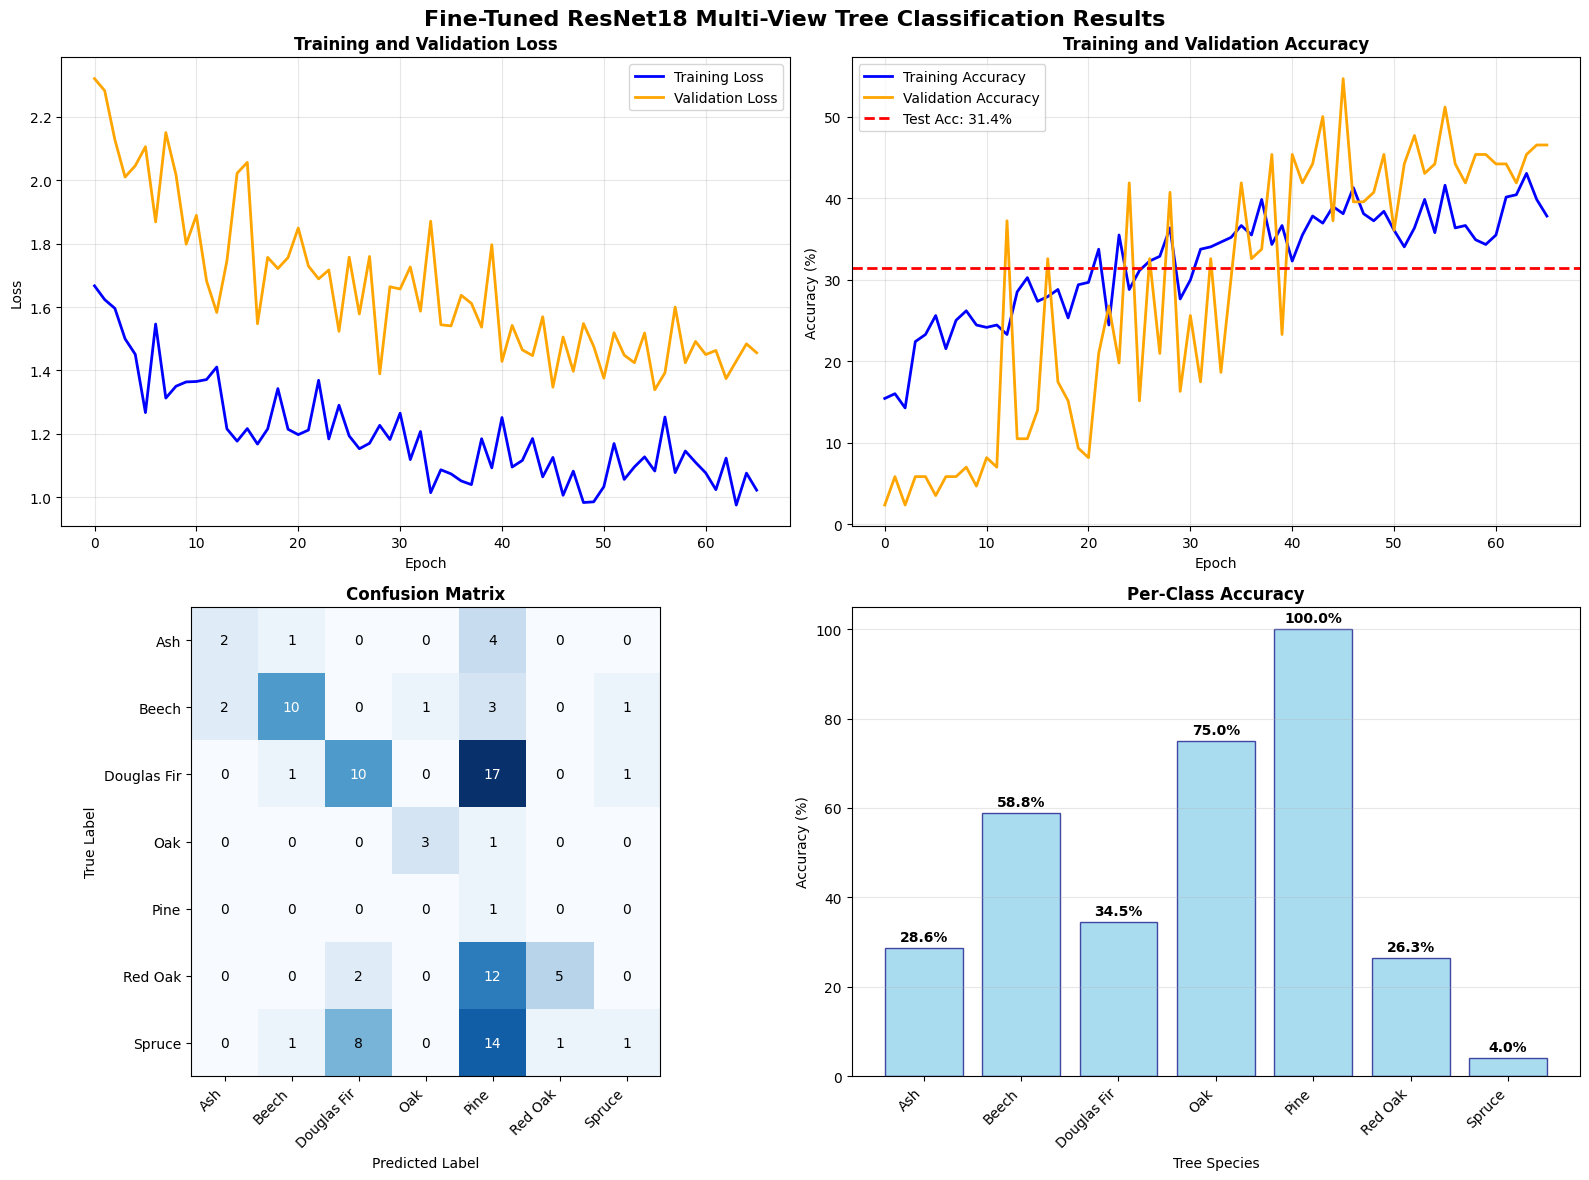


📈 Model Performance Summary:
Metric               Value     
------------------------------
Test Accuracy        31.37%
Best Val Accuracy    54.65%
Mean F1-Score        0.385
Std F1-Score         0.249
Min Class Accuracy   4.0%
Max Class Accuracy   100.0%

🎉 Fine-tuning evaluation complete!
📁 Model saved as 'best_finetuned_resnet18.pt'


In [24]:
# Cell 8: Comprehensive Evaluation and Results Visualization
def evaluate_model(model, test_loader, label_encoder):
    """
    Comprehensive evaluation of the model on test set
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    print("🧪 Evaluating model on test set...")
    
    with torch.no_grad():
        for views, labels in test_loader:
            views, labels = views.to(DEVICE), labels.to(DEVICE)
            outputs = model(views)
            
            # Get predictions and probabilities
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Calculate test accuracy
    test_acc = accuracy_score(all_labels, all_preds) * 100
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs), test_acc

# Evaluate model
y_pred, y_true, y_probs, test_accuracy = evaluate_model(model, test_loader, label_encoder)

print(f"\n📈 Final Results:")
print(f"🎯 Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"🏆 Final Test Accuracy: {test_accuracy:.2f}%")

# Detailed classification report
class_names = label_encoder.classes_
print(f"\n📋 Detailed Classification Report:")
print("=" * 80)
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

# Per-class accuracy analysis
print(f"\n📊 Per-Class Accuracy Analysis:")
print("-" * 50)
cm = confusion_matrix(y_true, y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)

for i, class_name in enumerate(class_names):
    test_samples = np.sum(y_true == i)
    correct_predictions = cm[i, i]
    class_acc = per_class_acc[i] * 100
    print(f"{class_name:15s}: {correct_predictions:3d}/{test_samples:3d} = {class_acc:.1f}%")

# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Fine-Tuned ResNet18 Multi-View Tree Classification Results', fontsize=16, fontweight='bold')

# 1. Training History - Loss
axes[0, 0].plot(history['train_loss'], label='Training Loss', linewidth=2, color='blue')
axes[0, 0].plot(history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
axes[0, 0].set_title('Training and Validation Loss', fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Training History - Accuracy
axes[0, 1].plot(history['train_acc'], label='Training Accuracy', linewidth=2, color='blue')
axes[0, 1].plot(history['val_acc'], label='Validation Accuracy', linewidth=2, color='orange')
axes[0, 1].axhline(y=test_accuracy, color='red', linestyle='--', linewidth=2, label=f'Test Acc: {test_accuracy:.1f}%')
axes[0, 1].set_title('Training and Validation Accuracy', fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Confusion Matrix
im = axes[1, 0].imshow(cm, interpolation='nearest', cmap='Blues')
axes[1, 0].set_title('Confusion Matrix', fontweight='bold')
tick_marks = np.arange(len(class_names))
axes[1, 0].set_xticks(tick_marks)
axes[1, 0].set_yticks(tick_marks)
axes[1, 0].set_xticklabels(class_names, rotation=45, ha='right')
axes[1, 0].set_yticklabels(class_names)

# Add text annotations to confusion matrix
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        axes[1, 0].text(j, i, format(cm[i, j], 'd'),
                       ha="center", va="center",
                       color="white" if cm[i, j] > thresh else "black")

axes[1, 0].set_ylabel('True Label')
axes[1, 0].set_xlabel('Predicted Label')

# 4. Per-Class Performance
class_f1_scores = []
for i in range(len(class_names)):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    class_f1_scores.append(f1)

bars = axes[1, 1].bar(range(len(class_names)), per_class_acc * 100, alpha=0.7, color='skyblue', edgecolor='navy')
axes[1, 1].set_title('Per-Class Accuracy', fontweight='bold')
axes[1, 1].set_xlabel('Tree Species')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].set_xticks(range(len(class_names)))
axes[1, 1].set_xticklabels(class_names, rotation=45, ha='right')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add accuracy labels on bars
for i, (bar, acc) in enumerate(zip(bars, per_class_acc * 100)):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                   f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n📈 Model Performance Summary:")
print(f"{'Metric':<20} {'Value':<10}")
print("-" * 30)
print(f"{'Test Accuracy':<20} {test_accuracy:.2f}%")
print(f"{'Best Val Accuracy':<20} {best_val_acc:.2f}%")
print(f"{'Mean F1-Score':<20} {np.mean(class_f1_scores):.3f}")
print(f"{'Std F1-Score':<20} {np.std(class_f1_scores):.3f}")
print(f"{'Min Class Accuracy':<20} {np.min(per_class_acc * 100):.1f}%")
print(f"{'Max Class Accuracy':<20} {np.max(per_class_acc * 100):.1f}%")

print(f"\n🎉 Fine-tuning evaluation complete!")
print(f"📁 Model saved as 'best_finetuned_resnet18.pt'")

In [25]:
# Cell 9: Model Saving and Performance Analysis
# Save the fine-tuned model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'label_encoder': label_encoder,
    'num_classes': num_classes,
    'best_val_acc': best_val_acc,
    'test_acc': test_accuracy,
    'history': history,
    'class_names': class_names,
    'model_config': {
        'architecture': 'ResNet18',
        'feature_lr': FEATURE_LR,
        'classifier_lr': CLASSIFIER_LR,
        'batch_size': BATCH_SIZE,
        'img_size': IMG_SIZE
    }
}, 'best_finetuned_resnet18.pt')

print("✅ Model and training artifacts saved successfully!")

# Performance comparison summary
print(f"\n🔍 Performance Analysis:")
print("=" * 60)

# Class distribution vs performance correlation
print(f"\n📊 Class Distribution vs Performance:")
print(f"{'Class':<15} {'Train Samples':<13} {'Test Acc':<10} {'F1-Score':<10}")
print("-" * 60)

train_class_counts = Counter(train_labels_enc)
for i, class_name in enumerate(class_names):
    train_count = train_class_counts[i]
    class_acc = per_class_acc[i] * 100
    f1_score = class_f1_scores[i]
    print(f"{class_name:<15} {train_count:<13} {class_acc:<10.1f} {f1_score:<10.3f}")

# Learning rate analysis
print(f"\n📈 Learning Rate Schedule Analysis:")
initial_lr = history['learning_rates'][0][0]
final_lr = history['learning_rates'][-1][0]
lr_reduction = (initial_lr - final_lr) / initial_lr * 100
print(f"  Initial LR (features): {initial_lr:.2e}")
print(f"  Final LR (features): {final_lr:.2e}")
print(f"  LR reduction: {lr_reduction:.1f}%")

# Training efficiency metrics
total_epochs = len(history['train_loss'])
best_epoch = np.argmax(history['val_acc']) + 1
early_stop_savings = NUM_EPOCHS - total_epochs

print(f"\n⏱️ Training Efficiency:")
print(f"  Total epochs run: {total_epochs}")
print(f"  Best epoch: {best_epoch}")
print(f"  Early stopping saved: {early_stop_savings} epochs")
print(f"  Final train accuracy: {history['train_acc'][-1]:.2f}%")
print(f"  Final validation accuracy: {history['val_acc'][-1]:.2f}%")

# Overfitting analysis
train_val_gap = history['train_acc'][-1] - history['val_acc'][-1]
if train_val_gap > 10:
    print(f"  ⚠️  Overfitting detected: {train_val_gap:.1f}% gap between train/val")
elif train_val_gap > 5:
    print(f"  ⚡ Slight overfitting: {train_val_gap:.1f}% gap between train/val")
else:
    print(f"  ✅ Good generalization: {train_val_gap:.1f}% gap between train/val")

# Model complexity analysis
print(f"\n🧠 Model Complexity:")
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
params_per_class = trainable_params / num_classes
samples_per_param = len(train_dataset) / trainable_params

print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Parameters per class: {params_per_class:,.0f}")
print(f"  Training samples per parameter: {samples_per_param:.3f}")

if samples_per_param < 1:
    print(f"  ⚠️  Low sample-to-parameter ratio - risk of overfitting")
else:
    print(f"  ✅ Good sample-to-parameter ratio")

print(f"\n🏁 Fine-tuning pipeline completed successfully!")
print(f"📋 Results Summary:")
print(f"  🎯 Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"  🏆 Final Test Accuracy: {test_accuracy:.2f}%")
print(f"  📁 Model saved as: 'best_finetuned_resnet18.pt'")
print(f"  ⚡ Ready for comparison with your custom CNN!")

✅ Model and training artifacts saved successfully!

🔍 Performance Analysis:

📊 Class Distribution vs Performance:
Class           Train Samples Test Acc   F1-Score  
------------------------------------------------------------
Ash             16            28.6       0.364     
Beech           56            58.8       0.667     
Douglas Fir     93            34.5       0.408     
Oak             14            75.0       0.750     
Pine            6             100.0      0.038     
Red Oak         65            26.3       0.400     
Spruce          94            4.0        0.071     

📈 Learning Rate Schedule Analysis:
  Initial LR (features): 1.00e-03
  Final LR (features): 7.46e-05
  LR reduction: 92.5%

⏱️ Training Efficiency:
  Total epochs run: 66
  Best epoch: 46
  Early stopping saved: 14 epochs
  Final train accuracy: 37.79%
  Final validation accuracy: 46.51%
  ✅ Good generalization: -8.7% gap between train/val

🧠 Model Complexity:
  Total parameters: 11,309,639
  Trainable pa